In [ ]:
import pandas as pd
data = pd.read_csv('/content/gossipcop_fake.csv')
data = pd.read_csv('/content/gossipcop_real.csv')

In [ ]:
null_values = data.isnull().sum()
print(null_values)


id              0
news_url       13
title           0
tweet_ids    1058
dtype: int64


In [ ]:
data = data.dropna()

In [ ]:
data.head()

,id,news_url,title,tweet_ids
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...


In [ ]:
# Columns with null values to check for dropping the row
columns_with_nulls = ['id', 'news_url', 'title', 'tweet_ids']

# Dropping rows where any of the specified columns have missing values
data = data.dropna(subset=columns_with_nulls)


In [ ]:
data = data.fillna(value='10')

In [ ]:
# Default values for each column
values = {
    'id': 'No ID',
    'news_url': 'No URL',
    'title': 'No Title',
    'tweet_ids': 'No Tweets'
}

# Filling missing values in the dataset with the specified default values
data = data.fillna(value=values)


In [ ]:
#data = data.drop(columns=['movies'])

In [ ]:
null_values = data.isnull().sum()
print(null_values)

id           0
news_url     0
title        0
tweet_ids    0
dtype: int64


Epoch 1/10, Train Loss: 0.6543, Train Accuracy: 0.7106, Test Loss: 0.6240, Test Accuracy: 0.7386
Epoch 2/10, Train Loss: 0.6637, Train Accuracy: 0.7104, Test Loss: 0.5684, Test Accuracy: 0.7552
Epoch 3/10, Train Loss: 0.6395, Train Accuracy: 0.7187, Test Loss: 0.6074, Test Accuracy: 0.7216
Epoch 4/10, Train Loss: 0.6456, Train Accuracy: 0.7145, Test Loss: 0.5923, Test Accuracy: 0.7543
Epoch 5/10, Train Loss: 0.6368, Train Accuracy: 0.7198, Test Loss: 0.6631, Test Accuracy: 0.6748
Epoch 6/10, Train Loss: 0.6458, Train Accuracy: 0.7177, Test Loss: 0.6252, Test Accuracy: 0.7268
Epoch 7/10, Train Loss: 0.6360, Train Accuracy: 0.7208, Test Loss: 0.6119, Test Accuracy: 0.7360
Epoch 8/10, Train Loss: 0.6129, Train Accuracy: 0.7301, Test Loss: 0.6007, Test Accuracy: 0.7505
Epoch 9/10, Train Loss: 0.6111, Train Accuracy: 0.7318, Test Loss: 0.6230, Test Accuracy: 0.7548
Epoch 10/10, Train Loss: 0.6150, Train Accuracy: 0.7310, Test Loss: 0.6539, Test Accuracy: 0.6914
Average Train Loss: 0.6361, A

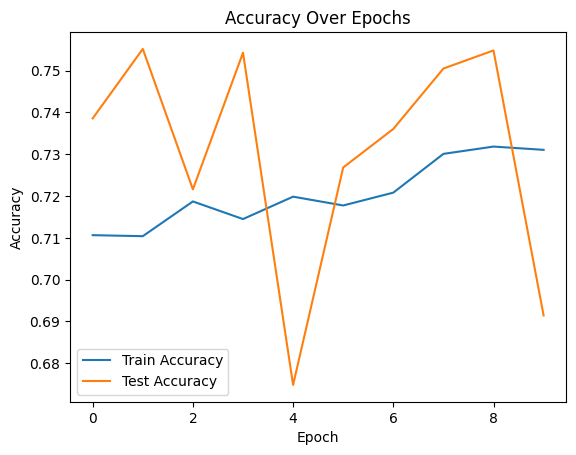

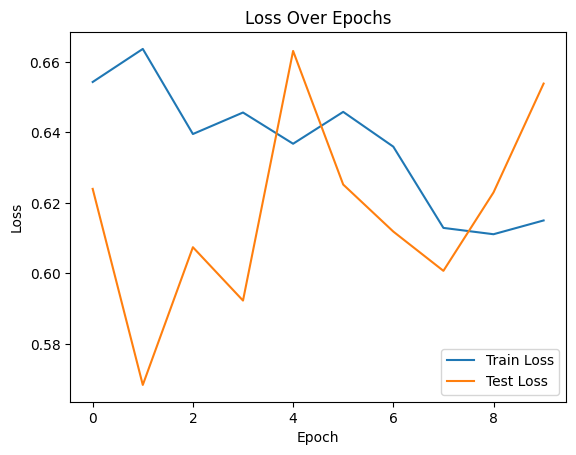

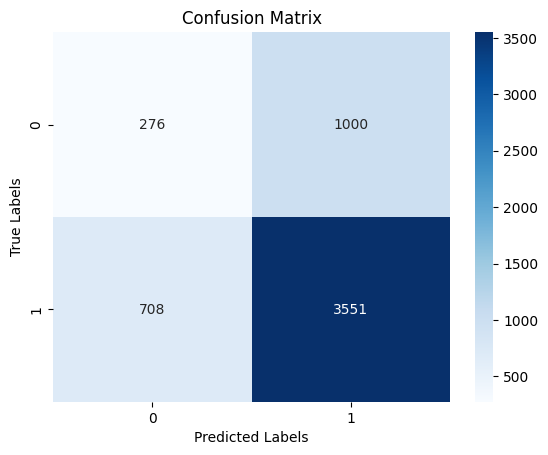

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_data(fake_path, real_path):
    fake = pd.read_csv(fake_path)
    real = pd.read_csv(real_path)
    fake['label'] = 0
    real['label'] = 1
    data = pd.concat([fake, real])
    data.dropna(subset=['title'], inplace=True)
    return data['title'].values, data['label'].values

# Create a dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.labels = labels
        self.texts = [torch.tensor(vocab(tokenizer(t)), dtype=torch.long) for t in texts]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Tokenizer
def tokenizer(text):
    return text.split()

# Build vocabulary
def build_vocab(texts):
    vocab = build_vocab_from_iterator(map(tokenizer, texts), specials=["<unk>", "<pad>"])
    vocab.set_default_index(vocab['<unk>'])
    return vocab

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Hyperparameters
embed_dim = 100
hidden_dim = 128
output_dim = 2
batch_size = 16
learning_rate = 0.05
num_epochs = 10

# Load dataset
fake_path = '/content/gossipcop_fake.csv'
real_path = '/content/gossipcop_real.csv'
texts, labels = load_data(fake_path, real_path)

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.25, random_state=123)

# Vocabulary
vocab = build_vocab(train_texts)

# Create datasets
train_dataset = NewsDataset(train_texts, train_labels, vocab)
test_dataset = NewsDataset(test_texts, test_labels, vocab)

# Custom collate function to pad text sequences and process labels
def collate_batch(batch):
    label_list, text_list = [], []
    for _text, _label in batch:
        label_list.append(_label)
        text_list.append(_text)
    text_list = pad_sequence(text_list, batch_first=True)
    label_list = torch.tensor(label_list, dtype=torch.long)
    return text_list, label_list

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)

# Model
model = LSTMClassifier(len(vocab), embed_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with tracking of loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0
    for texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        running_train_correct += (predicted == labels).sum().item()
        running_train_total += labels.size(0)
        loss.backward()
        optimizer.step()

    train_losses.append(running_train_loss / len(train_loader))
    train_accuracy = running_train_correct / running_train_total
    train_accuracies.append(train_accuracy)

    # Testing phase
    model.eval()
    running_test_loss = 0.0
    running_test_correct = 0
    running_test_total = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_test_correct += (predicted == labels).sum().item()
            running_test_total += labels.size(0)
            all_predicted.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    test_losses.append(running_test_loss / len(test_loader))
    test_accuracy = running_test_correct / running_test_total
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.4f}')

average_train_loss = sum(train_losses) / len(train_losses)
average_train_accuracy = sum(train_accuracies) / len(train_accuracies)
average_test_loss = sum(test_losses) / len(test_losses)
average_test_accuracy = sum(test_accuracies) / len(test_accuracies)

print(f'Average Train Loss: {average_train_loss:.4f}, Average Train Accuracy: {average_train_accuracy:.4f}')
print(f'Average Test Loss: {average_test_loss:.4f}, Average Test Accuracy: {average_test_accuracy:.4f}')

# Plotting the average values in the graphs
# For the accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

# For the loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
# Save the model
model_path = 'lstm_model.pth'
torch.save(model.state_dict(), model_path)

Epoch 1, Train Loss: 0.5217106154974486, Train Acc: 77.04305931948208, Test Loss: 0.4558820314490037, Test Acc: 80.75880758807588
Epoch 2, Train Loss: 0.39576010440111964, Train Acc: 83.17976513098465, Test Loss: 0.45242339316647867, Test Acc: 81.3550135501355
Epoch 3, Train Loss: 0.29064540426840785, Train Acc: 88.08190304125263, Test Loss: 0.4814006919741114, Test Acc: 81.13821138211382
Epoch 4, Train Loss: 0.22965346541801226, Train Acc: 90.82204155374887, Test Loss: 0.534486735358059, Test Acc: 79.47606142728094
Epoch 5, Train Loss: 0.19968446210809124, Train Acc: 92.2192110809997, Test Loss: 0.5772722381775435, Test Acc: 79.29539295392954
Epoch 6, Train Loss: 0.16731982939829063, Train Acc: 93.50797952423969, Test Loss: 0.6439314301992427, Test Acc: 78.98825654923216
Epoch 7, Train Loss: 0.1623361747947868, Train Acc: 93.77898223426679, Test Loss: 0.6586265701348382, Test Acc: 79.096657633243
Epoch 8, Train Loss: 0.14840029283814304, Train Acc: 94.194519722975, Test Loss: 0.719096

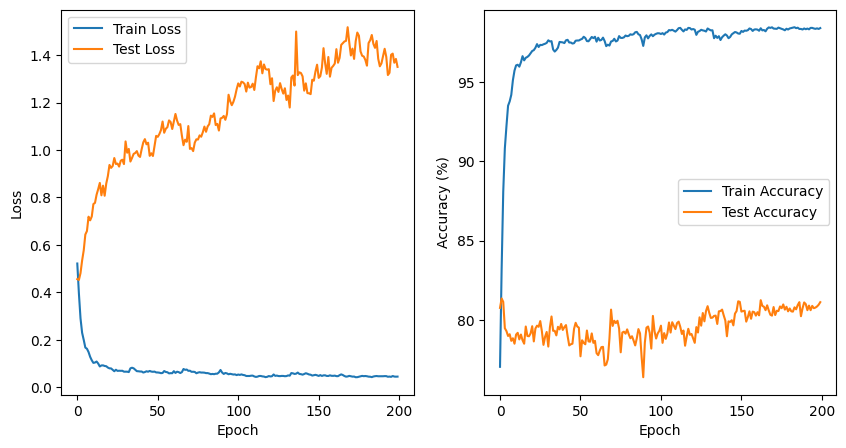

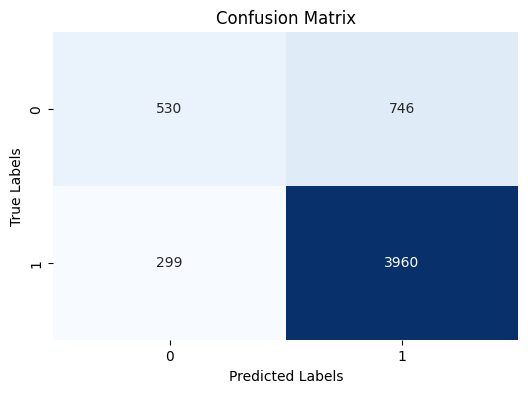

In [ ]:
#BI-LSTM
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_data(fake_path, real_path):
    fake = pd.read_csv(fake_path)
    real = pd.read_csv(real_path)
    fake['label'] = 0
    real['label'] = 1
    data = pd.concat([fake, real])
    data.dropna(subset=['title'], inplace=True)
    return data['title'].values, data['label'].values

# Create a dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.labels = labels
        self.texts = [torch.tensor(vocab(tokenizer(t)), dtype=torch.long) for t in texts]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Tokenizer
def tokenizer(text):
    return text.split()

# Build vocabulary
def build_vocab(texts):
    vocab = build_vocab_from_iterator(map(tokenizer, texts), specials=["<unk>", "<pad>"])
    vocab.set_default_index(vocab['<unk>'])
    return vocab

# BiLSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiplied by 2 for bidirectional output

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Hyperparameters
embed_dim = 100
hidden_dim = 128
output_dim = 2
batch_size = 16
learning_rate = 0.01
num_epochs = 200

# Load dataset
fake_path = '/content/gossipcop_fake.csv'
real_path = '/content/gossipcop_real.csv'
texts, labels = load_data(fake_path, real_path)

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.25, random_state=123)

# Vocabulary
vocab = build_vocab(train_texts)

# Create datasets
train_dataset = NewsDataset(train_texts, train_labels, vocab)
test_dataset = NewsDataset(test_texts, test_labels, vocab)

# Custom collate function to pad text sequences and process labels
def collate_batch(batch):
    label_list, text_list = [], []
    for _text, _label in batch:
        label_list.append(_label)
        text_list.append(_text)
    text_list = pad_sequence(text_list, batch_first=True)
    label_list = torch.tensor(label_list, dtype=torch.long)
    return text_list, label_list

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)

# Model
model = LSTMClassifier(len(vocab), embed_dim, hidden_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training and testing accuracy and loss
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(100 * correct / total)

    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0.0
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss_list.append(test_loss / len(test_loader))
        test_acc_list.append(100 * correct / total)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss_list[-1]}, Train Acc: {train_acc_list[-1]}, Test Loss: {test_loss_list[-1]}, Test Acc: {test_acc_list[-1]}')

# Print the average training and testing accuracy and loss
print(f'Average Train Loss: {sum(train_loss_list) / len(train_loss_list)}')
print(f'Average Train Accuracy: {sum(train_acc_list) / len(train_acc_list)}%')
print(f'Average Test Loss: {sum(test_loss_list) / len(test_loss_list)}')
print(f'Average Test Accuracy: {sum(test_acc_list) / len(test_acc_list)}%')

# Plotting the accuracy and loss graphs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Generate the confusion matrix
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model_path = 'bi_lstm_model.pth'
# Save the model
torch.save(model.state_dict(), model_path)

Epoch 1, Train Loss: 8.868960725682019, Train Accuracy: 71.39415838602831%, Test Loss: 7.582364851473526, Test Accuracy: 53.65853658536585%
Epoch 2, Train Loss: 4.556540445456594, Train Accuracy: 79.51821740439627%, Test Loss: 3.803580656119434, Test Accuracy: 80.0903342366757%
Epoch 3, Train Loss: 3.5306218686084745, Train Accuracy: 82.76422764227642%, Test Loss: 4.5973131563929215, Test Accuracy: 80.19873532068654%
Epoch 4, Train Loss: 2.4685748499596736, Train Accuracy: 83.58325805480277%, Test Loss: 7.454423627201489, Test Accuracy: 79.49412827461607%
Epoch 5, Train Loss: 2.0178642216855236, Train Accuracy: 85.01656127672388%, Test Loss: 10.153295353568607, Test Accuracy: 79.89159891598916%
Average Training Loss: 4.2885124222784565
Average Training Accuracy: 80.45528455284553%
Average Testing Loss: 6.718195528951196
Average Testing Accuracy: 74.66666666666666%


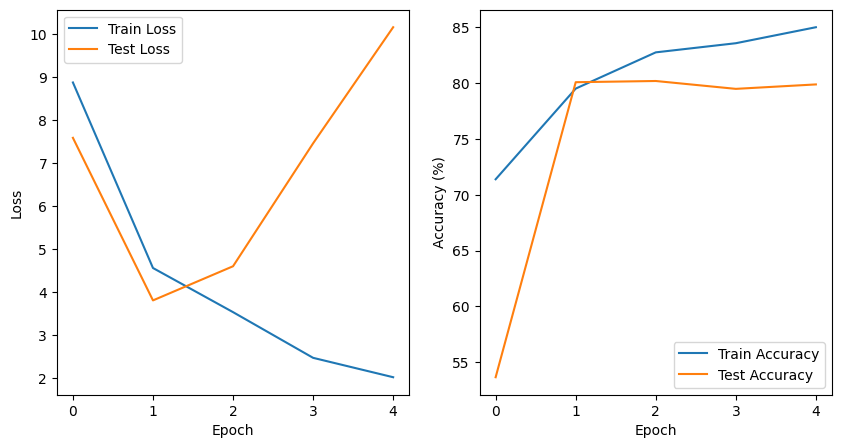

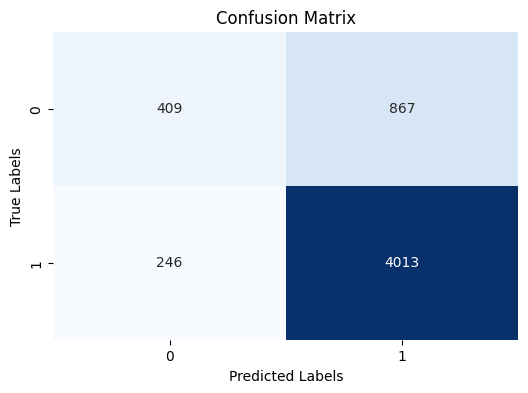

In [ ]:
#CNN
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_data(fake_path, real_path):
    fake = pd.read_csv(fake_path)
    real = pd.read_csv(real_path)
    fake['label'] = 0
    real['label'] = 1
    data = pd.concat([fake, real])
    data.dropna(subset=['title'], inplace=True)
    return data['title'].values, data['label'].values

# Dataset Class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.labels = labels
        self.texts = [torch.tensor(vocab(tokenizer(t)), dtype=torch.long) for t in texts]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Tokenizer
def tokenizer(text):
    return text.split()

# Build vocabulary
def build_vocab(texts):
    vocab = build_vocab_from_iterator(map(tokenizer, texts), specials=["<unk>", "<pad>"])
    vocab.set_default_index(vocab['<unk>'])
    return vocab

# CNN Model for Text Classification
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, num_filters, filter_sizes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, num_filters, (k, embed_dim)) for k in filter_sizes]
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_length, embed_dim]
        x = x.unsqueeze(1)  # [batch_size, 1, seq_length, embed_dim]
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # list of [batch_size, num_filters, W]
        x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # list of [batch_size, num_filters]
        x = torch.cat(x, 1)  # [batch_size, num_filters * len(filter_sizes)]
        x = self.dropout(x)
        x = self.fc(x)  # [batch_size, num_classes]
        return x

# Hyperparameters
embed_dim = 100
num_classes = 2
batch_size = 4
learning_rate = 0.01
num_epochs = 5
num_filters = 100
filter_sizes = [3, 4, 5]  # Different sizes of filters

# Load dataset
fake_path = '/content/gossipcop_fake.csv'
real_path = '/content/gossipcop_real.csv'
texts, labels = load_data(fake_path, real_path)

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.25, random_state=123)

# Vocabulary
vocab = build_vocab(train_texts)

# Create datasets
train_dataset = NewsDataset(train_texts, train_labels, vocab)
test_dataset = NewsDataset(test_texts, test_labels, vocab)

# Custom collate function to pad text sequences and process labels
def collate_batch(batch):
    label_list, text_list = [], []
    for _text, _label in batch:
        label_list.append(_label)
        text_list.append(_text)
    text_list = pad_sequence(text_list, batch_first=True)
    label_list = torch.tensor(label_list, dtype=torch.long)
    return text_list, label_list

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)

# Model
model = TextCNN(len(vocab), embed_dim, num_classes, num_filters, filter_sizes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training and testing accuracy and loss
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        epoch_train_loss += loss.item()

    # Compute average training accuracy and loss for the epoch
    train_accuracy = 100 * correct_train / total_train
    train_loss = epoch_train_loss / len(train_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)

    # Test the model
    model.eval()
    with torch.no_grad():
        epoch_test_loss = 0
        correct_test = 0
        total_test = 0
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)

            # Compute testing accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            epoch_test_loss += loss.item()

        # Compute average testing accuracy and loss for the epoch
        test_accuracy = 100 * correct_test / total_test
        test_loss = epoch_test_loss / len(test_loader)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}%, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%')

# Print average training and testing accuracy and loss
avg_train_loss = sum(train_loss_list) / len(train_loss_list)
avg_train_acc = sum(train_acc_list) / len(train_acc_list)
avg_test_loss = sum(test_loss_list) / len(test_loss_list)
avg_test_acc = sum(test_acc_list) / len(test_acc_list)

print(f'Average Training Loss: {avg_train_loss}')
print(f'Average Training Accuracy: {avg_train_acc}%')
print(f'Average Testing Loss: {avg_test_loss}')
print(f'Average Testing Accuracy: {avg_test_acc}%')

# Plotting training and testing accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Generate and plot confusion matrix
model.eval()
with torch.no_grad():
    all_labels = []
    all_predictions = []
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_path = 'cnn_model.pth'
# Save the model
torch.save(model.state_dict(), model_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Fold 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid 

Epoch 1: Train Loss = 0.22406614137024305, Train Accuracy = 0.9313459801264679
Epoch 2: Train Loss = 0.28086008580759936, Train Accuracy = 0.8494241192411924
Epoch 3: Train Loss = 0.29367944130769913, Train Accuracy = 0.890356820234869
Epoch 4: Train Loss = 0.32331352284331255, Train Accuracy = 0.865063233965673
Epoch 5: Train Loss = 0.6401094579707424, Train Accuracy = 0.7574525745257452
Validation Accuracy: 0.75903342366757
Test Accuracy: 0.75903342366757
Fold 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train Loss = 0.13573709667206835, Train Accuracy = 0.9829494128274616
Epoch 2: Train Loss = 0.27131707706365, Train Accuracy = 0.9096093044263776
Epoch 3: Train Loss = 0.24563233322163586, Train Accuracy = 0.9186427280939475
Epoch 4: Train Loss = 0.2803751088446637, Train Accuracy = 0.9007452574525745
Epoch 5: Train Loss = 0.579668532084428, Train Accuracy = 0.768970189701897
Validation Accuracy: 0.7642276422764227
Test Accuracy: 0.7642276422764227
Fold 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.23486800800778423, Train Accuracy = 0.9462511291779584
Epoch 2: Train Loss = 0.21094558856348222, Train Accuracy = 0.9273373983739837
Epoch 3: Train Loss = 0.2951738739364327, Train Accuracy = 0.9001806684733513
Epoch 4: Train Loss = 0.4127819310325217, Train Accuracy = 0.8215898825654923
Epoch 5: Train Loss = 0.6117186964150474, Train Accuracy = 0.7538956639566395
Validation Accuracy: 0.7574525745257452
Test Accuracy: 0.7574525745257452
Fold 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.15140684385083164, Train Accuracy = 0.9509372177055103
Epoch 2: Train Loss = 0.20662471573621494, Train Accuracy = 0.9493563685636855
Epoch 3: Train Loss = 0.3196273239702996, Train Accuracy = 0.888550135501355
Epoch 4: Train Loss = 0.25247452345229987, Train Accuracy = 0.9040198735320686
Epoch 5: Train Loss = 0.4089974373538643, Train Accuracy = 0.7987240289069557
Validation Accuracy: 0.7570009033423667
Test Accuracy: 0.7570009033423667
Fold 5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.21067259921553497, Train Accuracy = 0.9369918699186991
Epoch 2: Train Loss = 0.33087785894769667, Train Accuracy = 0.8496499548328816
Epoch 3: Train Loss = 0.3509117027470386, Train Accuracy = 0.8572154471544715
Epoch 4: Train Loss = 0.4057389563933863, Train Accuracy = 0.7791892502258355
Epoch 5: Train Loss = 0.6351869256246596, Train Accuracy = 0.7269083107497741
Validation Accuracy: 0.7601626016260162
Test Accuracy: 0.7601626016260162
Average Training Accuracy: 0.7611901535682023
Average Validation Accuracy: 0.7595754290876242


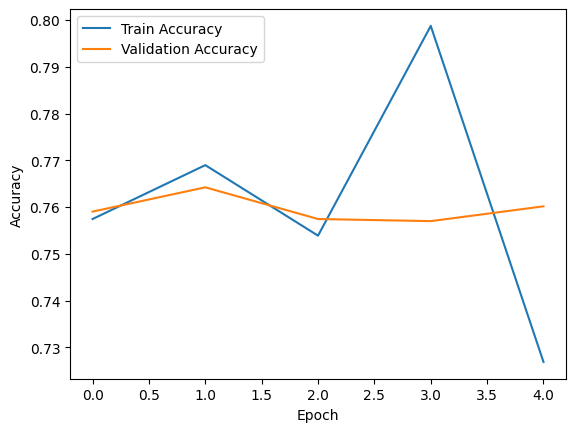

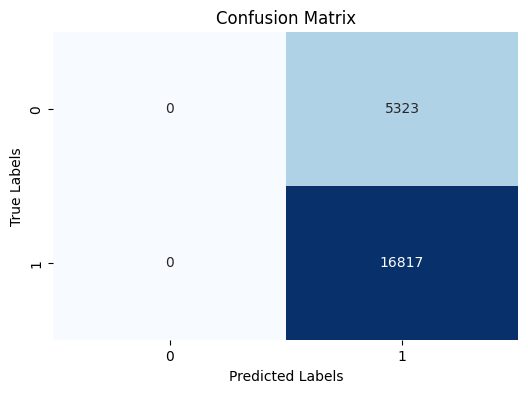

In [1]:
#BERT WITH K FOLD CV
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import numpy as np
import re
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_data(fake_path, real_path):
    fake = pd.read_csv(fake_path)
    real = pd.read_csv(real_path)
    fake['label'] = 0
    real['label'] = 1
    return pd.concat([fake, real])

# Clean text
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I | re.A)
    text = text.lower()
    return text

# BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset Class
class NewsDataset(Dataset):
    def __init__(self, titles, labels, tokenizer, max_len):
        self.titles = [clean_text(title) for title in titles]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, item):
        title = str(self.titles[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            title,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create Data Loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        titles=df.title.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

# Model Initialization
def initialize_model():
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    return model

# Training function
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        _, preds = torch.max(outputs[1], dim=1)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Testing function
def eval_model(model, data_loader, device):
    model = model.eval()
    correct_predictions = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs[0], dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

            correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset), all_labels, all_predictions

# Parameters
max_len = 128
batch_size = 16
num_epochs = 5

# Load dataset
df = load_data('/content/gossipcop_fake.csv', '/content/gossipcop_real.csv')
df['title'] = df['title'].apply(clean_text)

# Setting up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Training with cross-validation
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f'Fold {fold + 1}')
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

    train_data_loader = create_data_loader(train_df, tokenizer, max_len, batch_size)
    val_data_loader = create_data_loader(val_df, tokenizer, max_len, batch_size)

    model = initialize_model().to(device)
    optimizer = AdamW(model.parameters(), lr=1e-6, correct_bias=False)
    total_steps = len(train_data_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch in range(num_epochs):
        train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device, scheduler)
        print(f'Epoch {epoch + 1}: Train Loss = {train_loss}, Train Accuracy = {train_acc}')

    # Evaluate on validation set
    val_acc, _, _ = eval_model(model, val_data_loader, device)
    print(f'Validation Accuracy: {val_acc}')

    # Evaluate on test set (optional)
    test_data_loader = create_data_loader(val_df, tokenizer, max_len, batch_size)
    test_acc, test_labels, test_predictions = eval_model(model, test_data_loader, device)
    print(f'Test Accuracy: {test_acc}')

    results.append({'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc, 'test_labels': test_labels, 'test_predictions': test_predictions})

# Calculate average training accuracy and validation accuracy
train_acc_avg = np.mean([x['train_acc'].cpu().numpy() for x in results])
val_acc_avg = np.mean([x['val_acc'].cpu().numpy() for x in results])
print(f'Average Training Accuracy: {train_acc_avg}')
print(f'Average Validation Accuracy: {val_acc_avg}')

# Plotting the accuracy and loss graphs
train_accuracies = []
val_accuracies = []
for fold_result in results:
    train_accuracies.append(fold_result['train_acc'].cpu().numpy())
    val_accuracies.append(fold_result['val_acc'].cpu().numpy())

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Generate the confusion matrix
all_test_labels = np.concatenate([x['test_labels'] for x in results])
all_test_predictions = np.concatenate([x['test_predictions'] for x in results])
conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [2]:

model_path = 'bert_kfoldcv_model.pth'
# Save the model
torch.save(model.state_dict(), model_path)